In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from entsoe import EntsoePandasClient

In [2]:
my_api_key = os.environ.get('ENTSOE_API_KEY')
client = EntsoePandasClient(api_key=my_api_key)

# Parameters of the dataset

In [3]:
country_code = 'HU'
years = [('2018-01-01', '2018-12-31'),
         ('2019-01-01', '2019-12-31'),
         ('2020-01-01', '2020-12-31'),
         ('2021-01-01', '2021-12-31'),
         ('2022-01-01', '2022-12-31'),
         ('2023-01-01', '2023-12-31'),
         ('2024-01-01', '2024-03-24')]

In [4]:
prices_folder_path = './data/prices'
loads_folder_path = './data/loads'
wind_solar_forecast_folder_path = './data/wind_solar_forecast'
weather_folder_path = './data/weather'

In [5]:
def get_base_df_filename(country_code, years):
    return f'./data/base_price_{country_code}_{years[0]}_{years[-1]}.csv'

def get_base_load_df_filename(country_code, years):
    return f'./data/base_load_avgs_{country_code}_{years[0]}_{years[-1]}.csv'

def get_base_wind_solar_forecast_df_filename(country_code, years):
    return f'./data/base_wind_solar_forecast_avgs_{country_code}_{years[0]}_{years[-1]}.csv'

In [6]:
def run_querry_day_ahead_prices(country_code, start_date, end_date):
    filename = f'price_{start_date}_{end_date}_{country_code}.csv'
    start_ts = pd.Timestamp(start_date, tz='Europe/Budapest')
    end_ts = pd.Timestamp(end_date, tz='Europe/Budapest')

    if os.path.exists(f'{prices_folder_path}/{filename}'):
        print(f'{prices_folder_path}/{filename} exists, reading from file')
        #load
        df = pd.read_csv(f'{prices_folder_path}/{filename}', index_col=0)
    else:
        print(f'{prices_folder_path}/{filename} does not exist, downloading from ENTSO-E')

        #set start time to 00:00:00 and end time to 23:59:59
        start_ts = pd.Timestamp(start_date, tz='Europe/Brussels')
        end_ts = pd.Timestamp(end_date, tz='Europe/Brussels') + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

        df = client.query_day_ahead_prices(country_code, start=start_ts, end=end_ts)        # Data from ENTSO-E
        
        df.to_csv(f'{prices_folder_path}/{filename}')

    return df

In [7]:
def run_querry_load(country_code, start_date, end_date):
    filename = f'load_{start_date}_{end_date}_{country_code}.csv'
    start_ts = pd.Timestamp(start_date, tz='Europe/Budapest')
    end_ts = pd.Timestamp(end_date, tz='Europe/Budapest')

    if os.path.exists(f'{loads_folder_path}/{filename}'):
        print(f'{loads_folder_path}/{filename} exists, reading from file')
        #load
        df = pd.read_csv(f'{loads_folder_path}/{filename}', index_col=0)
    else:
        print(f'{loads_folder_path}/{filename} does not exist, downloading from ENTSO-E')

        #set start time to 00:00:00 and end time to 23:59:59
        start_ts = pd.Timestamp(start_date, tz='Europe/Brussels')
        end_ts = pd.Timestamp(end_date, tz='Europe/Brussels') + pd.Timedelta(days=1)

        df =client.query_load(country_code, start=start_ts, end=end_ts)        # Data from ENTSO-E
        
        df.to_csv(f'{loads_folder_path}/{filename}')

    return df

In [8]:
def run_querry_wind_solar_forecast(country_code, start_date, end_date):
    filename = f'wind_solar_forecast_{start_date}_{end_date}_{country_code}.csv'
    start_ts = pd.Timestamp(start_date, tz='Europe/Budapest')
    end_ts = pd.Timestamp(end_date, tz='Europe/Budapest')

    if os.path.exists(f'{wind_solar_forecast_folder_path}/{filename}'):
        print(f'{wind_solar_forecast_folder_path}/{filename} exists, reading from file')
        #load
        df = pd.read_csv(f'{wind_solar_forecast_folder_path}/{filename}', index_col=0)
    else:
        print(f'{wind_solar_forecast_folder_path}/{filename} does not exist, downloading from ENTSO-E')

        #set start time to 00:00:00 and end time to 23:59:59
        start_ts = pd.Timestamp(start_date, tz='Europe/Brussels')
        end_ts = pd.Timestamp(end_date, tz='Europe/Brussels') + pd.Timedelta(days=1)

        df =client.query_wind_and_solar_forecast(country_code, start=start_ts, end=end_ts)        # Data from ENTSO-E
        
        df.to_csv(f'{wind_solar_forecast_folder_path}/{filename}')

    return df

# Create the base concatenated df

First we will create a base concatenated dataframe with all the data from the different files but only the prices

In [9]:
def get_base_prices(country_code, years=years):
    base_df_filename = get_base_df_filename(country_code, years)
    if os.path.exists(base_df_filename):
        print(f'{base_df_filename} exists, reading from file')
        df = pd.read_csv(base_df_filename, index_col=0, parse_dates=True)
    else:
        print(f'{base_df_filename} does not exist, concatenating from multiple files')

        for (start_date, end_date) in years:
            df_temp = run_querry_day_ahead_prices(country_code, start_date, end_date)

            df = df_temp if (start_date, end_date) == years[0] else pd.concat([df, df_temp])

        df.columns = [f'Price_{country_code}']
        df['Datetime'] = df.index
        df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
        df.reset_index(drop=True, inplace=True)
        #order by datetime
        df = df.sort_values(by='Datetime')
        df = df.set_index('Datetime')
        #add 1 hour to the datetime
        df.index = df.index + pd.DateOffset(hours=1)
        df.to_csv(base_df_filename)
    return df

In [10]:
def load_15min_to_hourly(df, col_name, target_col_name):
    df['Date'] = df.index.floor('h')
    df[target_col_name] = df.groupby('Date')[col_name].transform('mean')
    df2 = df[['Date', target_col_name]]
    df2 = df2.drop_duplicates()
    return df

In [11]:
def get_base_load_avg(country_code, years=years):
    base_load_df_filename = get_base_load_df_filename(country_code, years)
    if os.path.exists(base_load_df_filename):
        print(f'{base_load_df_filename} exists, reading from file')
        df = pd.read_csv(base_load_df_filename, index_col=0, parse_dates=True)
    else:
        print(f'{base_load_df_filename} does not exist, concatenating from multiple files')

        for (start_date, end_date) in years:

            df_temp = run_querry_load(country_code, start_date, end_date)

            df = df_temp if (start_date, end_date) == years[0] else pd.concat([df, df_temp])
            
        df['Datetime'] = df.index
        df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
        df.reset_index(drop=True, inplace=True)
        #order by datetime
        df = df.sort_values(by='Datetime')
        df = df.set_index('Datetime')
        #add 1 hour to the datetime
        df.index = df.index + pd.DateOffset(hours=1)
        df = load_15min_to_hourly(df, 'Actual Load', 'Load_avg')
        df = df[['Date', 'Load_avg']].drop_duplicates()
        df.drop(columns=['Date'], inplace=True)
        df.columns = [f'Load_avg_{country_code}']
        df.to_csv(base_load_df_filename)
    return df

In [12]:
def get_base_wind_solar_forecast_avg(country_code, years=years):
    base_wind_solar_forecast_df_filename = get_base_wind_solar_forecast_df_filename(country_code, years)
    if os.path.exists(base_wind_solar_forecast_df_filename):
        print(f'{base_wind_solar_forecast_df_filename} exists, reading from file')
        df = pd.read_csv(base_wind_solar_forecast_df_filename, index_col=0, parse_dates=True)
    else:
        print(f'{base_wind_solar_forecast_df_filename} does not exist, concatenating from multiple files')

        for (start_date, end_date) in years:

            df_temp = run_querry_wind_solar_forecast(country_code, start_date, end_date)

            df = df_temp if (start_date, end_date) == years[0] else pd.concat([df, df_temp])
            
        df['Datetime'] = df.index
        df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
        df.reset_index(drop=True, inplace=True)
        #order by datetime
        df = df.sort_values(by='Datetime')
        df = df.set_index('Datetime')
        #add 1 hour to the datetime
        df.index = df.index + pd.DateOffset(hours=1)
        df = load_15min_to_hourly(df, 'Solar', 'Solar_Fcast_avg')
        df = load_15min_to_hourly(df, 'Wind Onshore', 'Wind_Onshore_avg')

        df = df[['Date', 'Solar_Fcast_avg', 'Wind_Onshore_avg']].drop_duplicates()
        df.drop(columns=['Date'], inplace=True)
        df.columns = [f'Solar_Fcast_avg_{country_code}', f'Wind_Onshore_avg_{country_code}']
        df.to_csv(base_wind_solar_forecast_df_filename)
    return df

In [13]:
def get_base_df(country_codes):
    for country_code in country_codes:
        print('Starting to collect data for', country_code)
        prices_df = get_base_prices(country_code)
        load_avg_df = get_base_load_avg(country_code)
        wind_solar_forecast_df = get_base_wind_solar_forecast_avg(country_code)
        
        df = pd.concat([prices_df, load_avg_df, wind_solar_forecast_df], axis=1)
        df = df.dropna()
        df = df.reset_index()
        df = df.rename(columns={'index': 'Datetime'})
        df_final = df if country_code == country_codes[0] else pd.merge(df_final, df, on='Datetime', how='inner')

    return df_final

In [14]:
country_codes = ['HU', 'RO', 'AT']
df = get_base_df(country_codes)

Starting to collect data for HU
./data/base_price_HU_('2018-01-01', '2018-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
./data/base_load_avgs_HU_('2018-01-01', '2018-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
./data/base_wind_solar_forecast_avgs_HU_('2018-01-01', '2018-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file


Starting to collect data for RO
./data/base_price_RO_('2018-01-01', '2018-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
./data/base_load_avgs_RO_('2018-01-01', '2018-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
./data/base_wind_solar_forecast_avgs_RO_('2018-01-01', '2018-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
Starting to collect data for AT
./data/base_price_AT_('2018-01-01', '2018-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
./data/base_load_avgs_AT_('2018-01-01', '2018-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file
./data/base_wind_solar_forecast_avgs_AT_('2018-01-01', '2018-12-31')_('2024-01-01', '2024-03-24').csv exists, reading from file


In [15]:
df

,Datetime,Price_HU,Load_avg_HU,Solar_Fcast_avg_HU,Wind_Onshore_avg_HU,Price_RO,Load_avg_RO,Solar_Fcast_avg_RO,Wind_Onshore_avg_RO,Price_AT,Load_avg_AT,Solar_Fcast_avg_AT,Wind_Onshore_avg_AT
0,2019-01-01 00:00:00+00:00,59.90,4082.00,0.0,19.75,279.00,6110.00,0.0,88.00,33.48,6075.00,0.0,487.0
1,2019-01-01 01:00:00+00:00,52.71,3985.75,0.0,27.25,245.54,5856.00,0.0,95.00,39.76,5852.75,0.0,398.0
2,2019-01-01 02:00:00+00:00,36.49,3732.50,0.0,19.75,169.98,5675.00,0.0,90.00,39.78,5619.25,0.0,338.0
3,2019-01-01 03:00:00+00:00,31.24,3554.25,0.0,7.25,145.52,5570.00,0.0,86.00,27.87,5324.00,0.0,309.0
4,2019-01-01 04:00:00+00:00,25.98,3499.25,0.0,1.75,121.00,5524.00,0.0,83.00,-0.36,5273.50,0.0,320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45654,2024-03-24 19:00:00+00:00,85.22,5588.50,0.0,63.25,85.46,6560.25,1.0,1105.25,80.25,6573.75,0.0,1421.0
45655,2024-03-24 20:00:00+00:00,76.51,5461.00,0.0,65.75,76.65,6317.25,1.0,1016.75,72.20,6335.75,0.0,1618.0
45656,2024-03-24 21:00:00+00:00,73.74,5193.50,0.0,68.00,73.68,5877.25,1.0,928.25,69.52,6060.25,0.0,1760.0
45657,2024-03-24 22:00:00+00:00,70.07,4897.25,0.0,71.75,70.10,5498.75,1.0,938.75,67.32,5977.25,0.0,1823.0


## Concatenate weather data

In [16]:
#create a filenames list for the weather data
weather_filenames = os.listdir(weather_folder_path)

#concat the weather data
for weather_filename in weather_filenames:
    if weather_filename == weather_filenames[0]:
        df_weather = pd.read_csv(f'{weather_folder_path}/{weather_filename}', index_col=0)
    else:
        df_temp = pd.read_csv(f'{weather_folder_path}/{weather_filename}', index_col=0)
        df_weather = pd.concat([df_weather, df_temp])


In [17]:
df_weather['Datetime'] = pd.to_datetime(df_weather.index)
df_weather.reset_index(drop=True, inplace=True)

In [18]:
df_weather

,temperature_2m_BP,relative_humidity_2m_BP,pressure_msl_BP,surface_pressure_BP,precipitation_BP,rain_BP,cloud_cover_BP,cloud_cover_low_BP,cloud_cover_mid_BP,cloud_cover_high_BP,...,shortwave_radiation_Konstanca,direct_radiation_Konstanca,diffuse_radiation_Konstanca,sunshine_duration_Konstanca,wind_speed_10m_Konstanca,wind_speed_100m_Konstanca,wind_direction_10m_Konstanca,wind_direction_100m_Konstanca,wind_gusts_10m_Konstanca,Datetime
0,-3.579,95.965530,1029.6,1014.72410,0.0,0.0,100.0,96.0,0.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:00+00:00
1,-4.429,95.937294,1029.4,1014.48020,0.0,0.0,65.4,44.0,0.0,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 01:00:00+00:00
2,-6.079,95.514830,1028.7,1013.69916,0.0,0.0,61.8,41.0,0.0,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 02:00:00+00:00
3,-5.729,95.893540,1028.3,1013.32450,0.0,0.0,54.6,32.0,0.0,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 03:00:00+00:00
4,-5.279,99.244804,1027.9,1012.95520,0.0,0.0,44.1,47.0,0.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,11.304229,26.987997,217.23491,223.91916,20.519999,2024-03-24 19:00:00+00:00
126716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,10.799999,26.220753,216.86998,224.44382,18.359999,2024-03-24 20:00:00+00:00
126717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,12.313894,28.284640,217.87505,222.42080,20.160000,2024-03-24 21:00:00+00:00
126718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,12.496719,28.817993,258.36640,257.00537,20.519999,2024-03-24 22:00:00+00:00


In [19]:
#fill na values with the mean of the column
df_weather = df_weather.fillna(df_weather.mean())

In [20]:
df = pd.merge(df, df_weather, on='Datetime', how='inner')

In [21]:
df

,Datetime,Price_HU,Load_avg_HU,Solar_Fcast_avg_HU,Wind_Onshore_avg_HU,Price_RO,Load_avg_RO,Solar_Fcast_avg_RO,Wind_Onshore_avg_RO,Price_AT,...,cloud_cover_high_Konstanca,shortwave_radiation_Konstanca,direct_radiation_Konstanca,diffuse_radiation_Konstanca,sunshine_duration_Konstanca,wind_speed_10m_Konstanca,wind_speed_100m_Konstanca,wind_direction_10m_Konstanca,wind_direction_100m_Konstanca,wind_gusts_10m_Konstanca
0,2019-01-01 00:00:00+00:00,59.90,4082.00,0.0,19.75,279.00,6110.00,0.0,88.00,33.48,...,32.472285,168.67298,111.766667,56.906313,1293.836029,13.287690,21.843457,191.885643,182.570640,25.860005
1,2019-01-01 00:00:00+00:00,59.90,4082.00,0.0,19.75,279.00,6110.00,0.0,88.00,33.48,...,0.000000,0.00000,0.000000,0.000000,0.000000,10.105681,20.326454,355.914460,22.932130,16.199999
2,2019-01-01 01:00:00+00:00,52.71,3985.75,0.0,27.25,245.54,5856.00,0.0,95.00,39.76,...,32.472285,168.67298,111.766667,56.906313,1293.836029,13.287690,21.843457,191.885643,182.570640,25.860005
3,2019-01-01 01:00:00+00:00,52.71,3985.75,0.0,27.25,245.54,5856.00,0.0,95.00,39.76,...,0.000000,0.00000,0.000000,0.000000,0.000000,11.212135,22.862123,5.527458,26.161512,19.440000
4,2019-01-01 02:00:00+00:00,36.49,3732.50,0.0,19.75,169.98,5675.00,0.0,90.00,39.78,...,32.472285,168.67298,111.766667,56.906313,1293.836029,13.287690,21.843457,191.885643,182.570640,25.860005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91313,2024-03-24 21:00:00+00:00,73.74,5193.50,0.0,68.00,73.68,5877.25,1.0,928.25,69.52,...,0.000000,0.00000,0.000000,0.000000,0.000000,12.313894,28.284640,217.875050,222.420800,20.160000
91314,2024-03-24 22:00:00+00:00,70.07,4897.25,0.0,71.75,70.10,5498.75,1.0,938.75,67.32,...,32.472285,168.67298,111.766667,56.906313,1293.836029,13.287690,21.843457,191.885643,182.570640,25.860005
91315,2024-03-24 22:00:00+00:00,70.07,4897.25,0.0,71.75,70.10,5498.75,1.0,938.75,67.32,...,1.000000,0.00000,0.000000,0.000000,0.000000,12.496719,28.817993,258.366400,257.005370,20.519999
91316,2024-03-24 23:00:00+00:00,66.02,4582.75,0.0,77.25,66.06,5216.25,0.0,1180.50,64.69,...,32.472285,168.67298,111.766667,56.906313,1293.836029,13.287690,21.843457,191.885643,182.570640,25.860005


# Create more input features

In [22]:
target_country_code = 'HU'

In [23]:
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour
df['weekday'] = df['Datetime'].dt.weekday
df['dayoftheweek'] = df['Datetime'].dt.dayofweek
df['date'] = df['Datetime'].dt.date

In [24]:
month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
dayofweek_dummies = pd.get_dummies(df['dayoftheweek'], prefix='dayofweek', drop_first=True)
df = pd.concat([df, month_dummies, dayofweek_dummies], axis=1)

In [25]:
dummy_columns = month_dummies.columns.tolist() + dayofweek_dummies.columns.tolist()

In [26]:
df['Datetime-2d'] = df['Datetime'] + pd.to_timedelta(-2, unit='day')
df['Datetime-7d'] = df['Datetime'] + pd.to_timedelta(-7, unit='day')

for country in country_codes:
    load_map = df.set_index('Datetime')[f'Price_{country}'].to_dict()

    df[f'Price_2d_{country}'] = df['Datetime-2d'].map(load_map)
    df[f'Price_7d_{country}'] = df['Datetime-7d'].map(load_map)


In [27]:
df.isnull().sum()

Datetime                 0
Price_HU                 0
Load_avg_HU              0
Solar_Fcast_avg_HU       0
Wind_Onshore_avg_HU      0
                      ... 
Price_7d_HU            698
Price_2d_RO            432
Price_7d_RO            698
Price_2d_AT            432
Price_7d_AT            698
Length: 82, dtype: int64

In [28]:
df = df.dropna().reset_index(drop=True)

In [29]:
df

,Datetime,Price_HU,Load_avg_HU,Solar_Fcast_avg_HU,Wind_Onshore_avg_HU,Price_RO,Load_avg_RO,Solar_Fcast_avg_RO,Wind_Onshore_avg_RO,Price_AT,...,dayofweek_5,dayofweek_6,Datetime-2d,Datetime-7d,Price_2d_HU,Price_7d_HU,Price_2d_RO,Price_7d_RO,Price_2d_AT,Price_7d_AT
0,2019-01-08 00:00:00+00:00,51.40,5069.50,0.0,22.50,181.78,6959.00,0.0,1456.00,42.02,...,False,False,2019-01-06 00:00:00+00:00,2019-01-01 00:00:00+00:00,50.81,59.90,236.99,279.00,52.46,33.48
1,2019-01-08 00:00:00+00:00,51.40,5069.50,0.0,22.50,181.78,6959.00,0.0,1456.00,42.02,...,False,False,2019-01-06 00:00:00+00:00,2019-01-01 00:00:00+00:00,50.81,59.90,236.99,279.00,52.46,33.48
2,2019-01-08 01:00:00+00:00,42.99,4876.25,0.0,31.75,170.46,6874.00,0.0,1397.00,38.06,...,False,False,2019-01-06 01:00:00+00:00,2019-01-01 01:00:00+00:00,47.95,52.71,223.69,245.54,49.02,39.76
3,2019-01-08 01:00:00+00:00,42.99,4876.25,0.0,31.75,170.46,6874.00,0.0,1397.00,38.06,...,False,False,2019-01-06 01:00:00+00:00,2019-01-01 01:00:00+00:00,47.95,52.71,223.69,245.54,49.02,39.76
4,2019-01-08 02:00:00+00:00,41.00,4672.50,0.0,32.00,161.23,6860.00,0.0,1347.00,39.05,...,False,False,2019-01-06 02:00:00+00:00,2019-01-01 02:00:00+00:00,46.07,36.49,214.92,169.98,49.01,39.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90287,2024-03-24 21:00:00+00:00,73.74,5193.50,0.0,68.00,73.68,5877.25,1.0,928.25,69.52,...,False,True,2024-03-22 21:00:00+00:00,2024-03-17 21:00:00+00:00,78.11,72.33,77.62,72.33,75.46,72.33
90288,2024-03-24 22:00:00+00:00,70.07,4897.25,0.0,71.75,70.10,5498.75,1.0,938.75,67.32,...,False,True,2024-03-22 22:00:00+00:00,2024-03-17 22:00:00+00:00,75.69,72.10,75.14,72.10,74.76,72.10
90289,2024-03-24 22:00:00+00:00,70.07,4897.25,0.0,71.75,70.10,5498.75,1.0,938.75,67.32,...,False,True,2024-03-22 22:00:00+00:00,2024-03-17 22:00:00+00:00,75.69,72.10,75.14,72.10,74.76,72.10
90290,2024-03-24 23:00:00+00:00,66.02,4582.75,0.0,77.25,66.06,5216.25,0.0,1180.50,64.69,...,False,True,2024-03-22 23:00:00+00:00,2024-03-17 23:00:00+00:00,72.81,65.91,72.19,65.91,71.82,65.91


In [31]:
from workalendar.europe import Hungary

cal = Hungary()
year_list = df['Datetime'].dt.year.unique()

In [32]:
holiday_df = pd.DataFrame()
for year in year_list:
    holidays = cal.holidays(year)
    temp_df = pd.DataFrame(holidays, columns=['date', 'holiday_name'])
    holiday_df = pd.concat([holiday_df, temp_df],
                           axis=0).reset_index(drop=True)

In [33]:
holiday_map = holiday_df.set_index('date')['holiday_name']
df['holiday_name'] = df['date'].map(holiday_map)
df['is_holiday'] = 0
df.loc[df['holiday_name'].notnull(), 'is_holiday'] = 1

df.drop(columns=['holiday_name'], inplace=True)

In [34]:
df['is_workday'] = 1
df.loc[df['is_holiday'] == 1, 'is_workday'] = 0
df.loc[df['dayoftheweek'].isin([5, 6]), 'is_workday'] = 0

# Evaluation metric

In [35]:
def base_eval(y_true, y_pred, do_print=True):
    error = np.mean(abs(y_true - y_pred))
    if do_print:
        print(f'Base evaluation (abs error): {error}')
    return error

In [36]:
def weighted_eval(y_true, y_pred, load, do_print=True):
    error = np.mean(abs((y_true - y_pred)*load))
    if do_print:
        print(f'Weighted evaluation (abs error): {error}')
    return error

In [38]:
def do_modeling(model, train_df, test_df, input_cols, target_col):
    model.fit(train_df[input_cols], train_df[target_col])
    y_pred = model.predict(test_df[input_cols])
    y_true = test_df[target_col]
    base_eval(y_true, y_pred)
    weighted_eval(y_true, y_pred, test_df['Load_avg'])

In [39]:
def plot_predictions(y_true, y_pred, model_name, x_ticks=None, x_tick_labels=None):
    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    if x_ticks is not None:
        plt.xticks(x_ticks, x_tick_labels)
        plt.xticks(rotation=90)
    plt.title(model_name)
    plt.legend()
    plt.show()

# Testing on models

In [40]:
df.head(1).T

,0
Datetime,2019-01-08 00:00:00+00:00
Price_HU,51.4
Load_avg_HU,5069.5
Solar_Fcast_avg_HU,0.0
Wind_Onshore_avg_HU,22.5
...,...
Price_7d_RO,279.0
Price_2d_AT,52.46
Price_7d_AT,33.48
is_holiday,0


In [41]:
test_end_date = '2024-03-17'

In [42]:
do_not_use_cols = ['Price_HU', 'Price_RO', 'Datetime', 'month', 'day', 'hour', 'weekday', 'dayoftheweek', 'date', 'Datetime-2d', 'Datetime-7d']

In [43]:
in_cols = set(df.columns.tolist()) - set(do_not_use_cols)
target_col = f'Price_{target_country_code}'

In [44]:
in_cols = list(in_cols)
in_cols

['Price_2d_AT',
 'cloud_cover_high_BP',
 'Wind_Onshore_avg_AT',
 'cloud_cover_high_Konstanca',
 'wind_gusts_10m_Konstanca',
 'dayofweek_6',
 'relative_humidity_2m_Konstanca',
 'month_12',
 'is_holiday',
 'Price_2d_RO',
 'Price_7d_RO',
 'wind_speed_10m_Konstanca',
 'shortwave_radiation_BP',
 'cloud_cover_low_Konstanca',
 'pressure_msl_Konstanca',
 'sunshine_duration_BP',
 'cloud_cover_low_BP',
 'direct_radiation_Konstanca',
 'pressure_msl_BP',
 'dayofweek_5',
 'precipitation_Konstanca',
 'wind_direction_100m_Konstanca',
 'dayofweek_3',
 'cloud_cover_mid_BP',
 'month_3',
 'Solar_Fcast_avg_RO',
 'temperature_2m_Konstanca',
 'relative_humidity_2m_BP',
 'month_7',
 'Price_AT',
 'month_10',
 'is_workday',
 'Price_2d_HU',
 'Solar_Fcast_avg_HU',
 'precipitation_BP',
 'month_11',
 'wind_gusts_10m_BP',
 'Price_7d_HU',
 'month_5',
 'month_9',
 'Wind_Onshore_avg_HU',
 'dayofweek_4',
 'Solar_Fcast_avg_AT',
 'Wind_Onshore_avg_RO',
 'wind_direction_10m_BP',
 'dayofweek_2',
 'Price_7d_AT',
 'rain_Kons

## Baseline

The baseline model is just shifting the prices by 1 week

In [45]:
def baseline_model(df):
    y_pred = df[f'Price_{target_country_code}'].shift(7*24)
    return y_pred

In [46]:
base_pred = baseline_model(df)
start_date = '2023-01-01'
end_date = '2024-03-17'
base_eval(df.loc[df['Datetime'] >= test_end_date, target_col], base_pred.loc[df['Datetime'] >= test_end_date])
weighted_eval(df.loc[df['Datetime'] >= test_end_date, target_col], base_pred.loc[df['Datetime'] >= test_end_date], df.loc[df['Datetime'] >= test_end_date, f'Load_avg_{target_country_code}'])

Base evaluation (abs error): 30.506822916666664
Weighted evaluation (abs error): 146463.39638020835


146463.39638020835

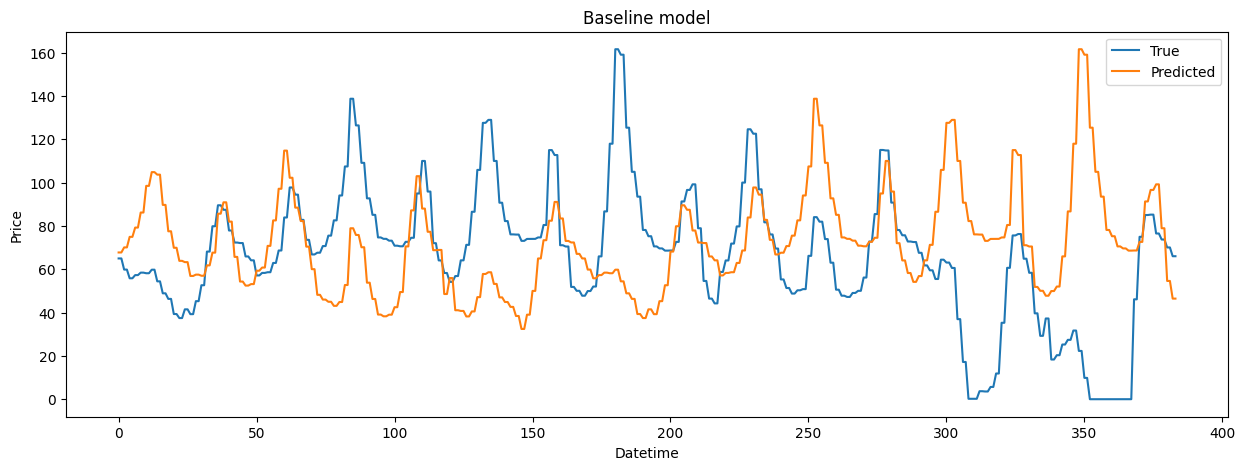

In [47]:
plot_predictions(df.loc[df['Datetime'] >= test_end_date, target_col].to_list(), base_pred.loc[df['Datetime'] >= test_end_date].to_list(), 'Baseline model')

## Baseline v2

The predicted value is based on the most similar hour in the history based on the input columns.

In [48]:
from sklearn.neighbors import NearestNeighbors

In [52]:
base2_cols = df.columns.tolist()
base2_cols = [col for col in base2_cols if col not in do_not_use_cols]
base2_cols.remove('Price_2d_HU')
base2_cols.remove('Price_7d_HU')
base2_cols

['Load_avg_HU',
 'Solar_Fcast_avg_HU',
 'Wind_Onshore_avg_HU',
 'Load_avg_RO',
 'Solar_Fcast_avg_RO',
 'Wind_Onshore_avg_RO',
 'Price_AT',
 'Load_avg_AT',
 'Solar_Fcast_avg_AT',
 'Wind_Onshore_avg_AT',
 'temperature_2m_BP',
 'relative_humidity_2m_BP',
 'pressure_msl_BP',
 'surface_pressure_BP',
 'precipitation_BP',
 'rain_BP',
 'cloud_cover_BP',
 'cloud_cover_low_BP',
 'cloud_cover_mid_BP',
 'cloud_cover_high_BP',
 'shortwave_radiation_BP',
 'direct_radiation_BP',
 'diffuse_radiation_BP',
 'sunshine_duration_BP',
 'wind_speed_10m_BP',
 'wind_speed_100m_BP',
 'wind_direction_10m_BP',
 'wind_direction_100m_BP',
 'wind_gusts_10m_BP',
 'temperature_2m_Konstanca',
 'relative_humidity_2m_Konstanca',
 'pressure_msl_Konstanca',
 'surface_pressure_Konstanca',
 'precipitation_Konstanca',
 'rain_Konstanca',
 'cloud_cover_Konstanca',
 'cloud_cover_low_Konstanca',
 'cloud_cover_mid_Konstanca',
 'cloud_cover_high_Konstanca',
 'shortwave_radiation_Konstanca',
 'direct_radiation_Konstanca',
 'diffuse_

In [53]:
K = 15
METRIC = "cosine"

def get_neighbors(index):
    curr_date = df.loc[index, 'date']
    X = df.loc[df['date'] < curr_date, base2_cols].values
    knn = NearestNeighbors(n_neighbors=K, metric=METRIC).fit(X)
    
    _, indices = knn.kneighbors(df.loc[index, base2_cols].values.reshape(1, -1))
    indices = indices[0].tolist()
    return [i for i in indices if df.loc[i, 'is_workday'] == df.loc[index, 'is_workday']]

In [54]:
def baseline_model2(df, date, target_col=target_col):
    datetimes = df.loc[df['date'] >= date, 'Datetime']
    y_pred = []
    for dt in datetimes:
        idx = df[df['Datetime'] == dt].index[0]
        neighbors = get_neighbors(idx)
        y_pred.append(df.loc[neighbors, target_col].mean())
    return y_pred

In [55]:
test_end_date_base2 = pd.Timestamp(test_end_date).date()
base2_pred = baseline_model2(df, test_end_date_base2)
base2_true = df.loc[df['date'] >= test_end_date_base2, target_col]
base_eval(base2_true, base2_pred)
weighted_eval(base2_true, base2_pred, df.loc[df['date'] >= test_end_date_base2, f'Load_avg_{target_country_code}'])

Base evaluation (abs error): 24.835597942422158
Weighted evaluation (abs error): 120900.85622853796


120900.85622853796

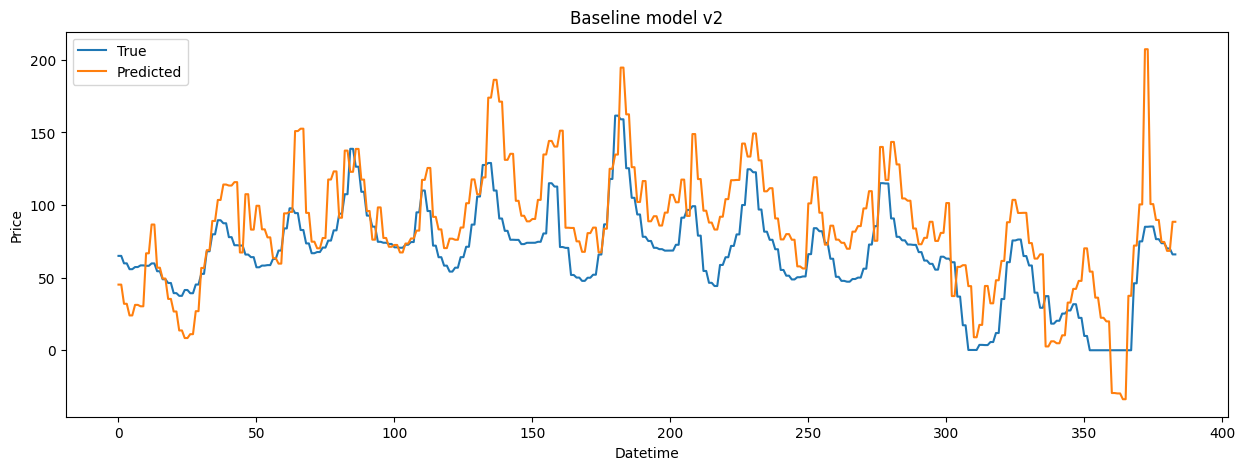

In [56]:
plot_predictions(base2_true.to_list(), base2_pred, 'Baseline model v2')

## ARIMA

As another base model

In [57]:
from statsmodels.tsa.arima.model import ARIMA

In [58]:
df_train = df.loc[df['Datetime'] < test_end_date]

In [59]:
model = ARIMA(df_train.loc[:,target_col], order=(7,2,1))
model = model.fit()

In [60]:
arima_pred = model.forecast(steps=len(df.loc[df['Datetime'] >= test_end_date]))

In [61]:
base_eval(df.loc[df['Datetime'] >= test_end_date, target_col], arima_pred)
weighted_eval(df.loc[df['Datetime'] >= test_end_date, target_col], arima_pred, df.loc[df['Datetime'] >= test_end_date, f'Load_avg_{target_country_code}'])

Base evaluation (abs error): 22.167304385995706
Weighted evaluation (abs error): 109043.25482454871


109043.25482454871

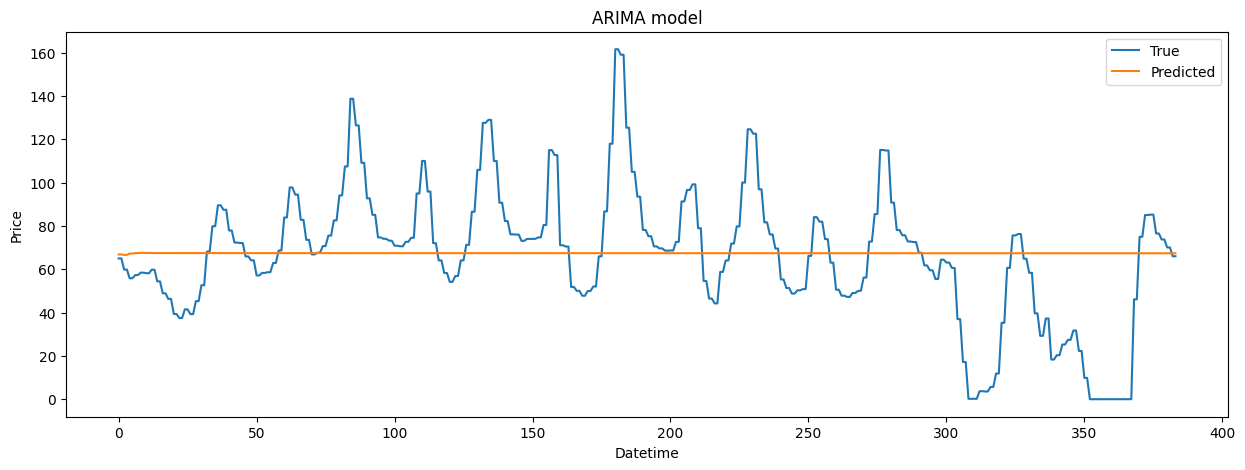

In [62]:
plot_predictions(df.loc[df['Datetime'] >= test_end_date, target_col].to_list(), arima_pred.to_list(), 'ARIMA model')

## Gradient Boosting Regressor

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

In [64]:
gbr = GradientBoostingRegressor(random_state=42)

In [65]:
train = df.loc[df['Datetime'] <= test_end_date]
test = df.loc[df['Datetime'] > test_end_date]

X_train = train[in_cols]
y_train = train[target_col]
X_test = test[in_cols]
y_test = test[target_col]

In [66]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [67]:
gbr_pred = gbr.predict(X_test)

In [68]:
base_eval(y_test, gbr_pred)
weighted_eval(y_test, gbr_pred, test[f'Load_avg_{target_country_code}'])

Base evaluation (abs error): 4.942276713070204
Weighted evaluation (abs error): 23938.75143426829


23938.75143426829

In [69]:
feature_importances = list(zip(X_train.columns, gbr.feature_importances_))
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances

[('Price_AT', 0.9471347059854989),
 ('Price_7d_HU', 0.02782246326842114),
 ('Price_2d_HU', 0.01357252949662121),
 ('Load_avg_HU', 0.002680883940209454),
 ('Price_7d_RO', 0.0021620489908962285),
 ('Wind_Onshore_avg_RO', 0.0017346486991400441),
 ('Load_avg_RO', 0.0016260645710391352),
 ('month_12', 0.0006558197735726815),
 ('Price_7d_AT', 0.0003892824293119598),
 ('month_8', 0.0002951686728249396),
 ('month_7', 0.0002917449649004333),
 ('month_10', 0.0002727118158635924),
 ('Solar_Fcast_avg_HU', 0.0002219549782782315),
 ('Price_2d_AT', 0.00019300395843663753),
 ('Solar_Fcast_avg_AT', 0.0001755853343344418),
 ('Price_2d_RO', 0.00011072087482454634),
 ('month_3', 8.257552867142173e-05),
 ('temperature_2m_BP', 5.952841549038832e-05),
 ('Wind_Onshore_avg_AT', 5.897913576565672e-05),
 ('Wind_Onshore_avg_HU', 5.5572713129317014e-05),
 ('relative_humidity_2m_BP', 5.090534043523029e-05),
 ('surface_pressure_Konstanca', 4.5318836791574965e-05),
 ('surface_pressure_BP', 4.1504058531295656e-05),
 (

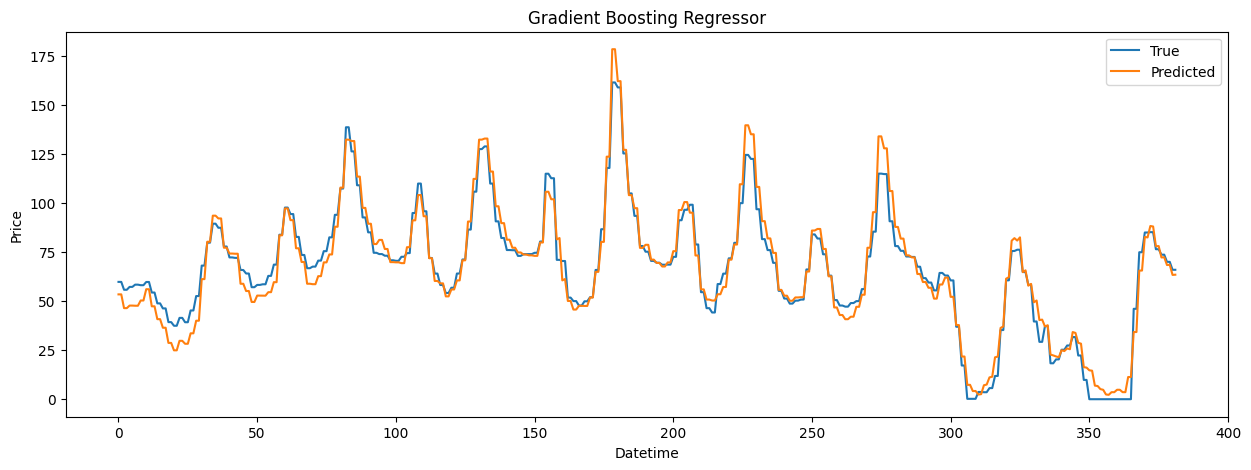

In [70]:
plot_predictions(y_test.to_list(), gbr_pred, 'Gradient Boosting Regressor')

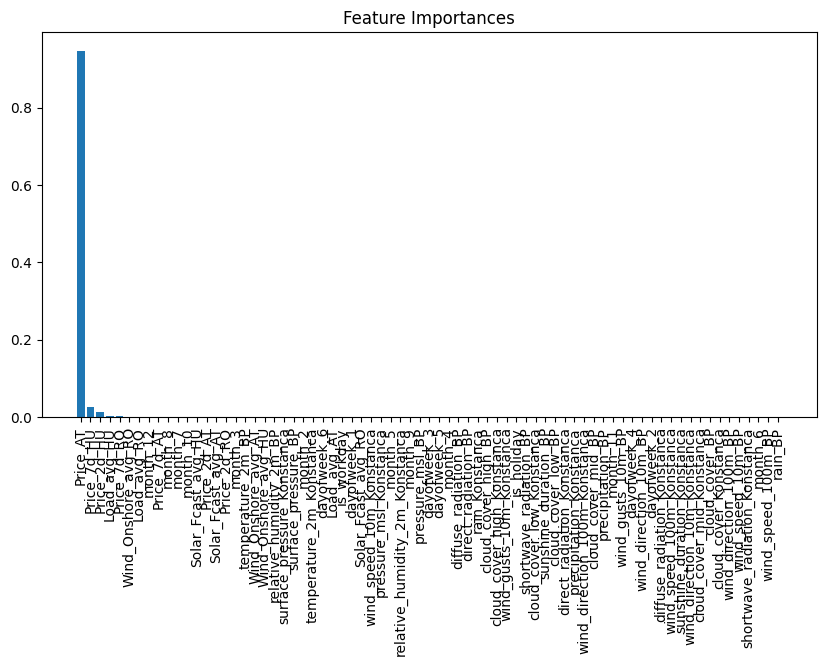

In [71]:
#plot the feature importances
plt.figure(figsize=(10,5))
plt.bar([x[0] for x in feature_importances], [x[1] for x in feature_importances])
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.show()

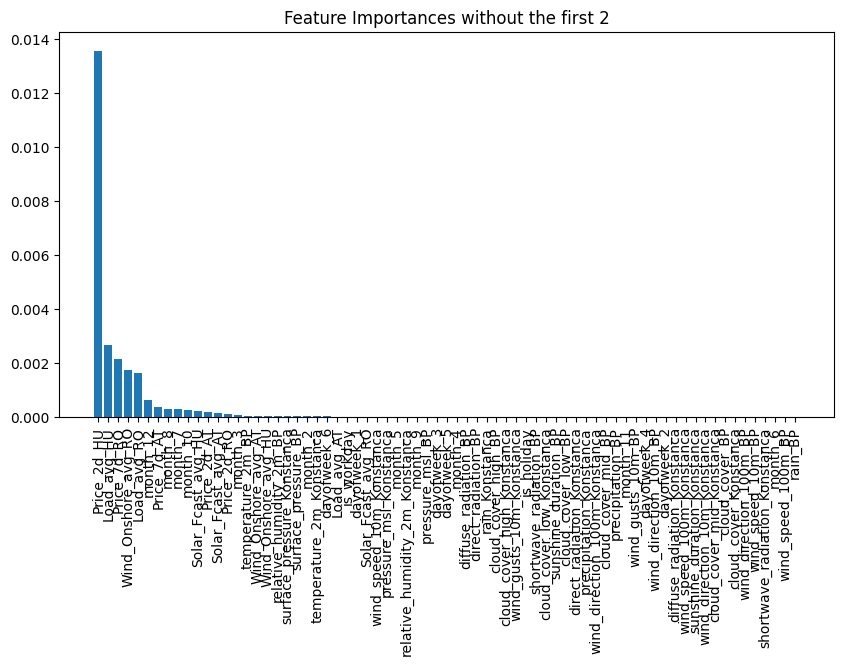

In [72]:
plt.figure(figsize=(10,5))
plt.bar([x[0] for x in feature_importances[2:]], [x[1] for x in feature_importances[2:]])
plt.xticks(rotation=90)
plt.title('Feature Importances without the first 2')
plt.show()

In [73]:
#list the features importances where the importance is 0
[x[0] for x in feature_importances if x[1] == 0]

['cloud_cover_high_BP',
 'cloud_cover_high_Konstanca',
 'wind_gusts_10m_Konstanca',
 'is_holiday',
 'shortwave_radiation_BP',
 'cloud_cover_low_Konstanca',
 'sunshine_duration_BP',
 'cloud_cover_low_BP',
 'direct_radiation_Konstanca',
 'precipitation_Konstanca',
 'wind_direction_100m_Konstanca',
 'cloud_cover_mid_BP',
 'precipitation_BP',
 'month_11',
 'wind_gusts_10m_BP',
 'dayofweek_4',
 'wind_direction_10m_BP',
 'dayofweek_2',
 'diffuse_radiation_Konstanca',
 'wind_speed_100m_Konstanca',
 'sunshine_duration_Konstanca',
 'wind_direction_10m_Konstanca',
 'cloud_cover_mid_Konstanca',
 'cloud_cover_BP',
 'cloud_cover_Konstanca',
 'wind_direction_100m_BP',
 'wind_speed_10m_BP',
 'shortwave_radiation_Konstanca',
 'month_6',
 'wind_speed_100m_BP',
 'rain_BP']

## Recurrent Neural Network

In [74]:
#recurrent neural network
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Input
import tensorflow as tf

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24

X_train_lstm, y_train_lstm = create_dataset(X_train, y_train, time_steps)
X_test_lstm, y_test_lstm = create_dataset(X_test, y_test, time_steps)

In [75]:
X_train_lstm = X_train_lstm.astype('float32')
y_train_lstm = y_train_lstm.astype('float32')
X_test_lstm = X_test_lstm.astype('float32')
y_test_lstm = y_test_lstm.astype('float32')

In [76]:
lstm = Sequential()
lstm.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm.add(LSTM(units=64))
lstm.add(Dropout(rate=0.2))
lstm.add(Dense(units=1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

In [77]:
X_train_lstm = tf.convert_to_tensor(X_train_lstm)
X_test_lstm = tf.convert_to_tensor(X_test_lstm)
y_train_lstm = tf.convert_to_tensor(y_train_lstm)
y_test_lstm = tf.convert_to_tensor(y_test_lstm)

In [78]:
history = lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 7413.4609 - val_loss: 2600.0173
Epoch 2/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 5216.0327 - val_loss: 1863.3850
Epoch 3/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 5121.2993 - val_loss: 1734.1981
Epoch 4/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 5638.2495 - val_loss: 1940.0601
Epoch 5/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 6140.5464 - val_loss: 2224.0945
Epoch 6/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 6703.0337 - val_loss: 2456.1982
Epoch 7/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7057.6216 - val_loss: 2622.5181
Epoch 8/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7306.0454 - val_loss: 2732.0759
Epoch 9/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7455.0786 - val_loss: 2806.9924
Epoch 10/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7570.9731 - val_loss: 2852.4109
Epoch 11/30
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 11s 4m

In [79]:
lstm_pred = lstm.predict(X_test_lstm)

lstm_pred = lstm_pred.reshape(lstm_pred.shape[0])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
base_eval(y_test_lstm, lstm_pred)
weighted_eval(y_test_lstm, lstm_pred, test[f'Load_avg_{target_country_code}'])

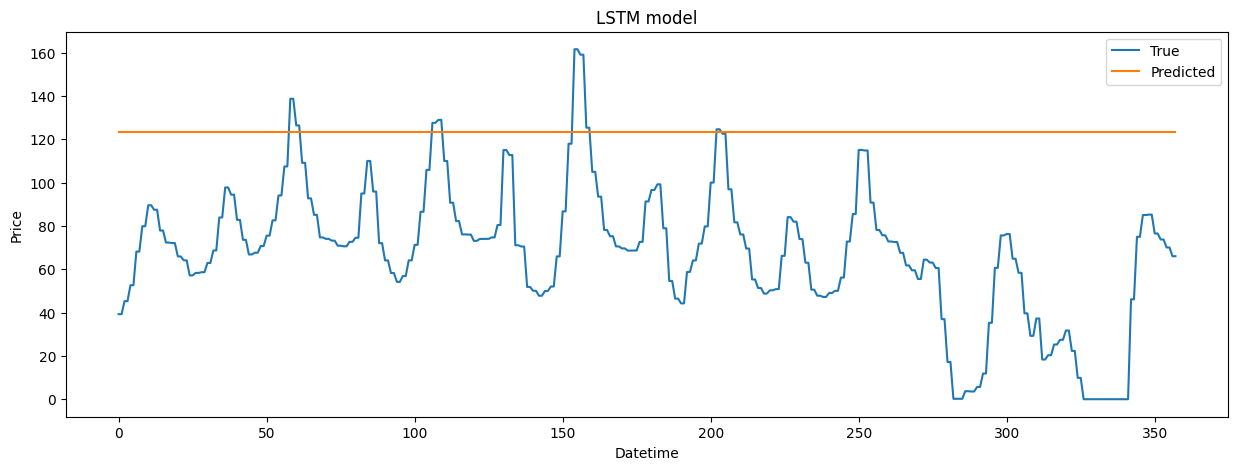

In [82]:
plot_predictions(y_test_lstm, lstm_pred, 'LSTM model')

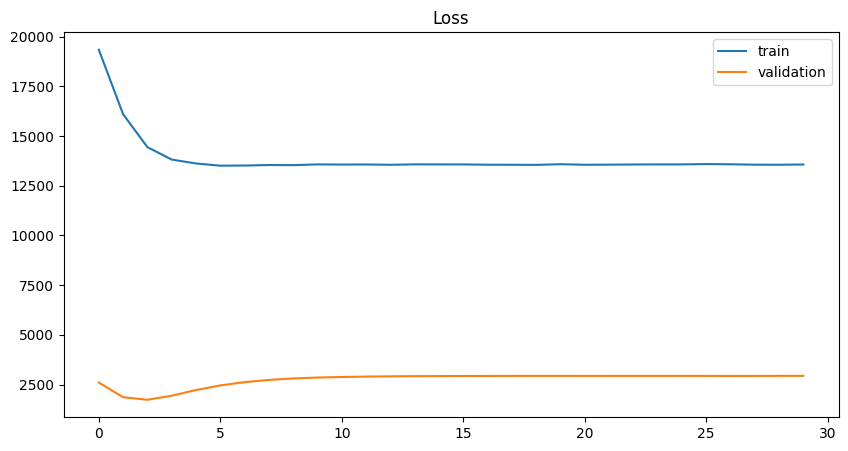

In [83]:



plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

# Framework

With this framework we can predict the prices for a couple of days and after predicting for a day the model train again with the new data.

In [84]:
test_period_start = pd.to_datetime('2024-01-01 09:00:00+00:00')
test_period_end = df.iloc[-1]['Datetime']

In [85]:
from tqdm import tqdm
import xgboost as xgb

In [86]:
xgb_base_loss = []
xgb_weighted_loss = []
xgb_pred = []

xdb_feature_importances = []


for date in tqdm(pd.date_range(start=test_period_start, end=test_period_end, freq='D')):
    next_day = date + pd.Timedelta(days=1)

    X_train = df.loc[(df['Datetime'] < date), in_cols]
    y_train = df.loc[(df['Datetime'] < date), target_col]
    X_test = df.loc[(df['Datetime'] >= date) & (df['Datetime'] < next_day), in_cols]
    y_test = df.loc[(df['Datetime'] >= date) & (df['Datetime'] < next_day), target_col]

    loads = df.loc[(df['Datetime'] >= date) & (df['Datetime'] < next_day), f'Load_avg_{target_country_code}']

    gbr = xgb.XGBRegressor(random_state=42, tree_method='hist', device='cuda').fit(X_train, y_train)
    gbr_pred = gbr.predict(X_test)

    xgb_pred.extend(gbr_pred)

    xgb_base_loss.append(base_eval(y_test, gbr_pred, do_print=False))
    xgb_weighted_loss.append(weighted_eval(y_test, gbr_pred, loads, do_print=False))

    xdb_feature_importances.append(list(zip(X_train.columns, gbr.feature_importances_)))

  0%|          | 0/84 [00:00<?, ?it/s]d:\Programs\miniconda\envs\pygpu\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
100%|██████████| 84/84 [01:20<00:00,  1.04it/s]


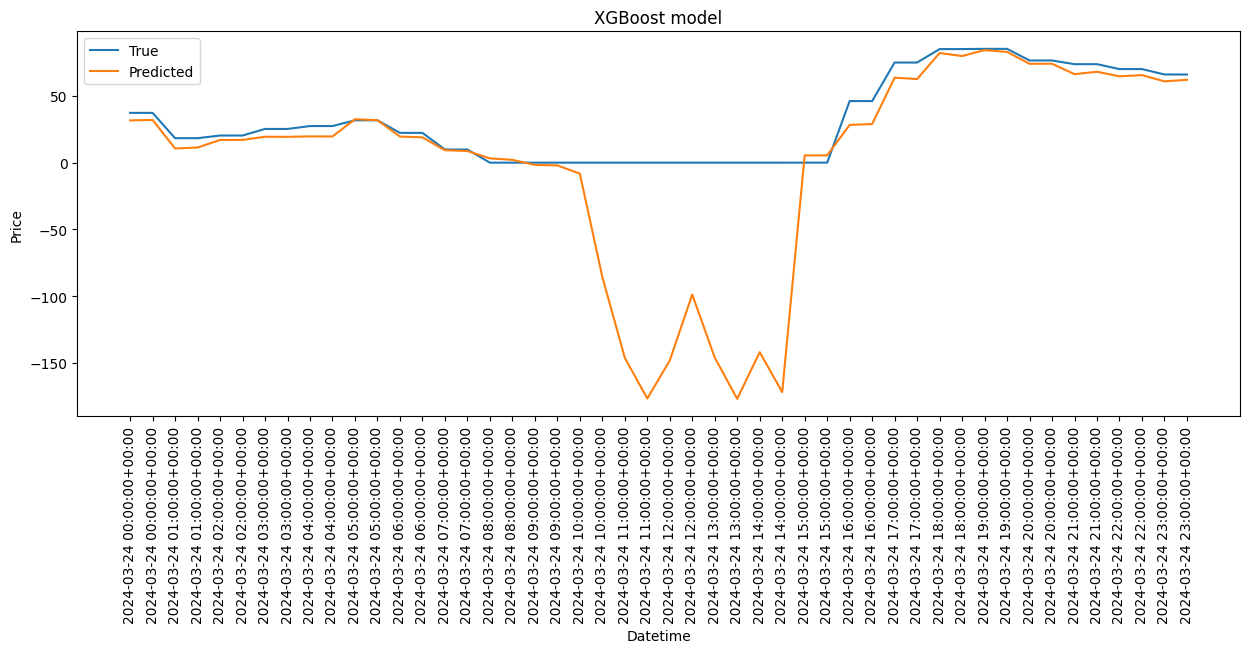

In [87]:
x_ticks = np.arange(0, 48)
x_tick_labels = df.loc[df['Datetime'] >= test_period_start, 'Datetime'].astype(str).to_list()[-48:]

plot_predictions(df.loc[df['Datetime'] >= test_period_start, target_col].to_list()[-48:], xgb_pred[-48:], 'XGBoost model', x_ticks, x_tick_labels)

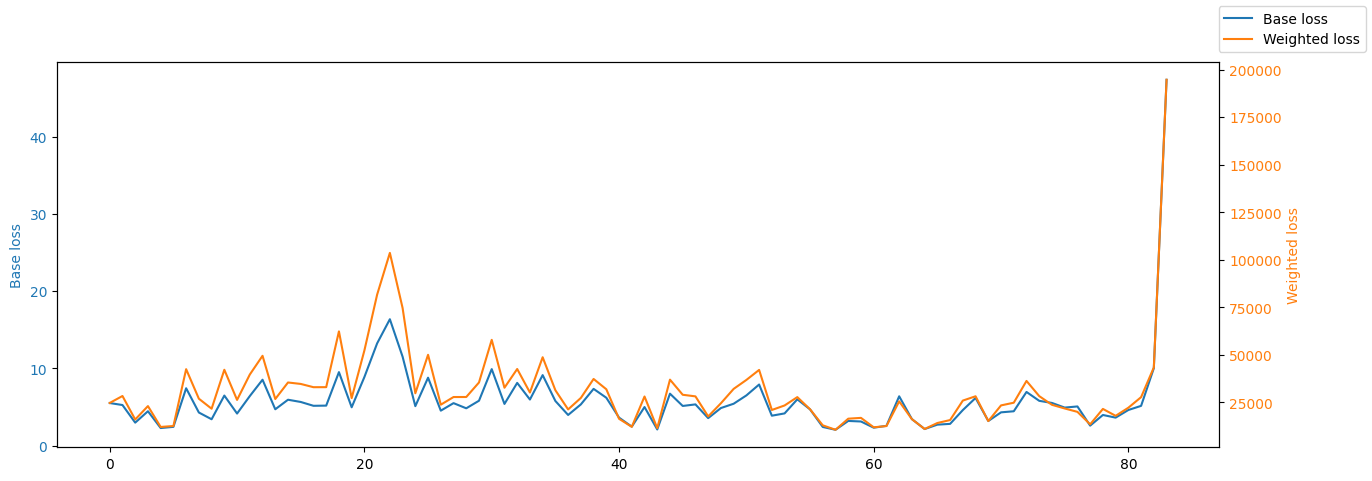

In [88]:
#plot the losses on the same subplot, use two y axis
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(xgb_base_loss, label='Base loss')
ax.set_ylabel('Base loss', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax.twinx()
ax2.plot(xgb_weighted_loss, color='tab:orange', label='Weighted loss')
ax2.set_ylabel('Weighted loss', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
fig.legend()


Text(0.5, 1.0, 'Feature importances of Price_7d_HU and Price_7d_RO')

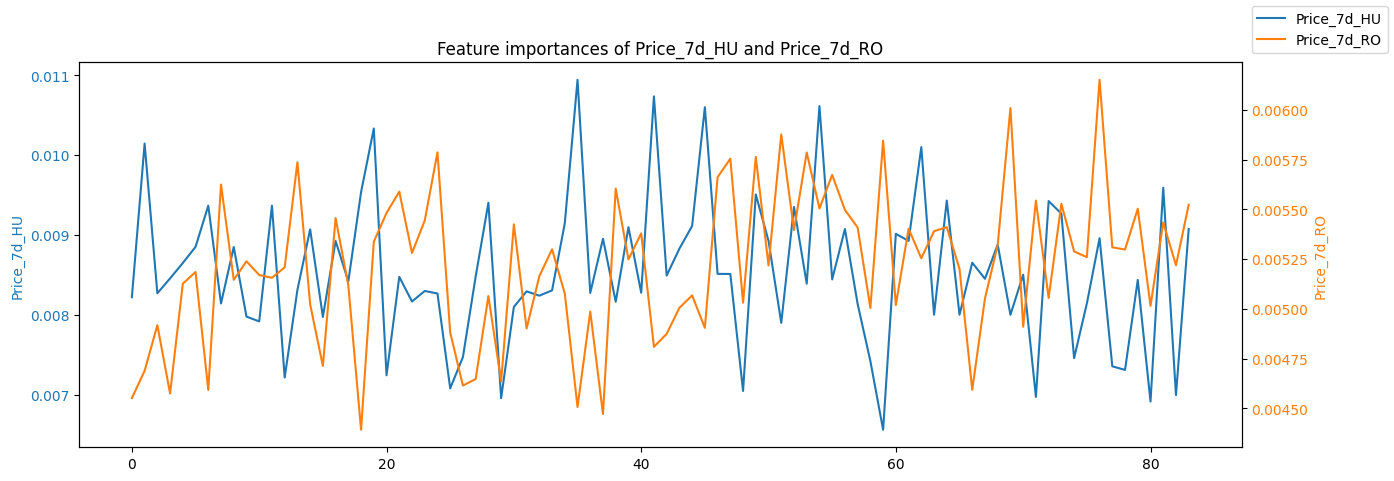

In [90]:
p_7d_hu = []
p_7d_ro = []
for fi in xdb_feature_importances:
    p_7d_hu.append([x[1] for x in fi if x[0] == 'Price_7d_HU'][0])
    p_7d_ro.append([x[1] for x in fi if x[0] == 'Price_7d_RO'][0])

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(p_7d_hu, label='Price_7d_HU')
ax.set_ylabel('Price_7d_HU', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax.twinx()
ax2.plot(p_7d_ro, color='tab:orange', label='Price_7d_RO')
ax2.set_ylabel('Price_7d_RO', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.legend()
plt.title('Feature importances of Price_7d_HU and Price_7d_RO')


# Notes

Ma 8as adatokkal 9ig a holnapit (a mait mind ismerem)
- baseline1 az 1 heti adat
- baseline2 hasonló időjárású nap

Kiértékelés:
- v1 abs hiba (hány eurót tévedtünk)
- v2 adott órában mennyi a load (termelés / fogyasztás), hiba súlyozva a teljes fogyasztással

Opciók
- recurrent nn predictor (?)
- gbm regressor
-- (előzö napi adatok, napelemek termelése, román adatok, hőmérséklet..., körny ország árai)
-- walk forward opt

keretrendszer
feture inportance alapján feature selection 
- változásuk követése !!!

(talán osztrák is számít, meg kell nézni melyik számít)

időjárási adatok (első körben tényadatok, nem előrejelzés) próbálkozni kell, drága lehet, kb kizárt 

- végén fontos és ***nem fontos*** változók listája

3 fontos időjárás (régiós, a napi bontás is jó)
- hány fok van (fűtés / hűtés)
- besugárzás
- szélerősség


-Hányszor volt negatív ár - statisztika róla (Meg tudjuk-e mondani, hogy mikor lesz negatív ár)
-- Ez is lehet célváltozó és kiértékelés

- Napi egy órát kikapcsoljuk, cél: mikor legyen (mert a többi órában többet tudunk termelni)
-- Meg lehet nézni, hogy melyik lesz a legdrágább óra
